In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps


In [4]:
class ShortConn2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        
        # my own modification, use average pooling instead of skipping pixels when stride is bigger than 1
        self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x= self.pool(x)
        return x

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # skip connect projection from 3 to 20 channels
        # 32x32 to 16x16 kernels with kernal size of 2 and stride of 2
        self.sc1 = ShortConn2d(3, 20, 2, 2)
        
        # skip connect projection from 3 to 20 channels
        # 32x32 to 8x8 kernels with kernal size of 4 and stride of 4
        self.sc2 = ShortConn2d(3, 20, 4, 4)
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # skip connect projection from 10 to 20 channels
        # 16x16 to 8x8 kernels with kernal size of 2 and stride of 2
        self.sc3 = ShortConn2d(10, 20, 2, 2)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(20)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # input image shape = 20x8x8
        self.conv3 = nn.Conv2d(20, 20, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(20)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # input image shape = 20x4x4
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 4 * 4, 100)
        self.bn4 = nn.BatchNorm1d(100)
        self.act4 = nn.ReLU()
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        res1 = self.sc1(x)
        res2 = self.sc2(x)
        # conv1 then relu then max pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        res3 = self.sc3(x)
        # conv2 relu max pool
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x + res1)
        x = self.pool2(x)
        
        # conv3 relu max pool
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x + res2 + res3)
        x = self.pool3(x)
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.fc2(x)
        return x
    

In [11]:
PATH = './cifar_res_deep_adam.pth'

epochs = 50             # Total epochs.
iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.
res_deep_avg_train_losses = []   # Avg. losses.
res_deep_train_accuracies, res_deep_test_accuracies = [], []  # Train and test accuracies.

res_deep = ResNet()     # Create the network instance.
res_deep.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(res_deep.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

# add scheduling
exp_scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = res_deep(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            res_deep_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
                            

    # exponential scheduling
    exp_scheduler.step()
        
    # Set the model to evaluation mode.
    res_deep.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    res_deep_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = res_deep(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    res_deep_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    res_deep.train()     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': res_deep.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': res_deep_avg_train_losses[epoch],
            'train_accuracy': res_deep_train_accuracies[epoch],
            'test_accuracy': res_deep_test_accuracies[epoch],
            }, PATH)
              

print('Finished Training.')

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.724
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.551
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.518
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.457
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.428
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.394
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.395
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.362
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.351
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.369
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.331
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.268
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.365
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.288
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.243
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

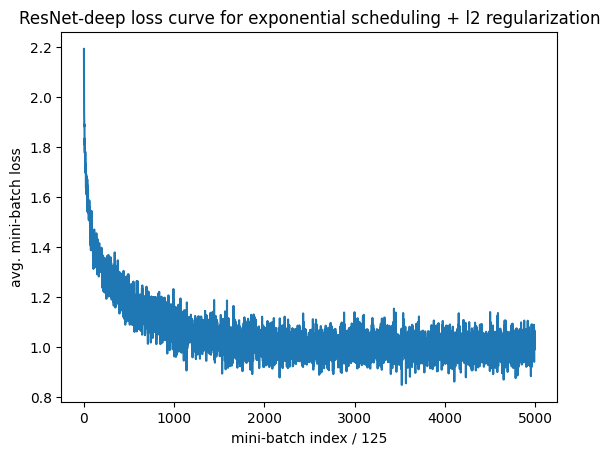

In [12]:
plt.plot(res_deep_avg_train_losses)
plt.title('ResNet-deep loss curve for exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

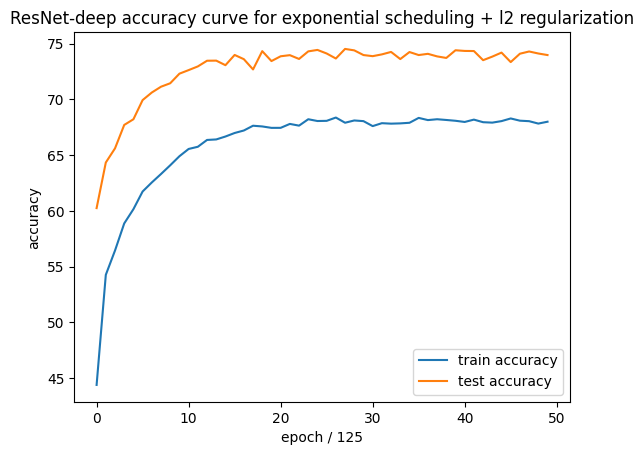

In [13]:
plt.plot(res_deep_train_accuracies)
plt.plot(res_deep_test_accuracies)
plt.title('ResNet-deep accuracy curve for exponential scheduling + l2 regularization')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

In [15]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

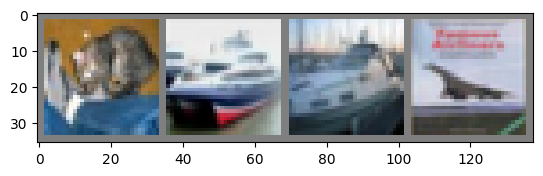

GroundTruth:    cat  ship  ship plane
Predicted:    dog   car horse plane


In [16]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = res_deep(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [17]:
res_deep.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res_deep(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74.02 %


In [10]:
res_deep.to(device)

res_deep.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res_deep(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73.98 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res_deep(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))